In [1]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from  tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import backend as keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
npy_file_path = '/content/drive/MyDrive/data/5624917336278880874.npy'

# Load the .npy file
data = np.load(npy_file_path)

In [6]:
def data_generator(directory, batch_size=32, target_size=(256, 256)):
    file_list = [f for f in os.listdir(directory) if f.endswith(".npy")]

    while True:
        np.random.shuffle(file_list)
        for i in range(0, len(file_list), batch_size):
            batch_files = file_list[i:i+batch_size]
            batch_images = []
            batch_labels = []

            for filename in batch_files:
                image_path = os.path.join(directory, filename)
                con = np.load(image_path)

                image = con[..., :-1]
                label = con[..., -1]


                image = image.astype(np.float32)
                label = label.astype(np.float32)

                image = cv2.resize(image, dsize=target_size, interpolation=cv2.INTER_AREA)
                label = cv2.resize(label, dsize=target_size, interpolation=cv2.INTER_AREA)

                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

In [7]:
data_directory = '/content/drive/MyDrive/data'
batch_size = 16
target_size = (256, 256)

all_images = np.empty((0, 256, 256, 3))  # Assuming your images are of shape (256, 256, 3)
all_labels = np.empty((0, 256, 256))

generator = data_generator(data_directory, batch_size=batch_size, target_size=target_size)

for i in range(10):
    batch_images, batch_labels = next(generator)
    all_images = np.concatenate((all_images, batch_images), axis=0)
    all_labels = np.concatenate((all_labels, batch_labels), axis=0)

    print(f"Batch {i + 1}: {batch_images.shape}, {batch_labels.shape}")

Batch 1: (16, 256, 256, 3), (16, 256, 256)
Batch 2: (16, 256, 256, 3), (16, 256, 256)
Batch 3: (16, 256, 256, 3), (16, 256, 256)
Batch 4: (16, 256, 256, 3), (16, 256, 256)
Batch 5: (16, 256, 256, 3), (16, 256, 256)
Batch 6: (16, 256, 256, 3), (16, 256, 256)
Batch 7: (16, 256, 256, 3), (16, 256, 256)
Batch 8: (16, 256, 256, 3), (16, 256, 256)
Batch 9: (16, 256, 256, 3), (16, 256, 256)
Batch 10: (16, 256, 256, 3), (16, 256, 256)


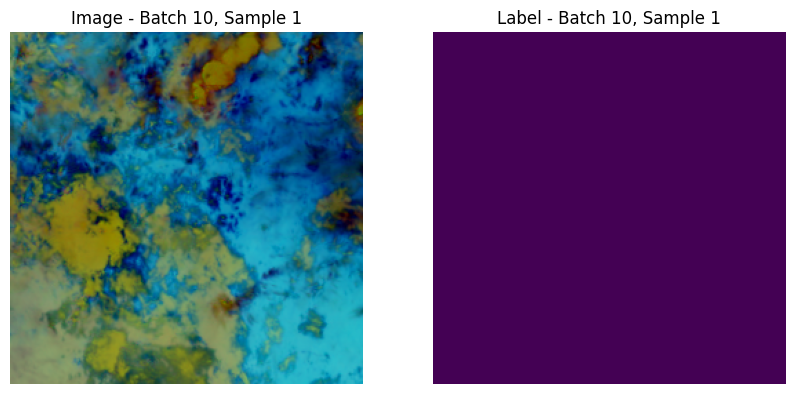

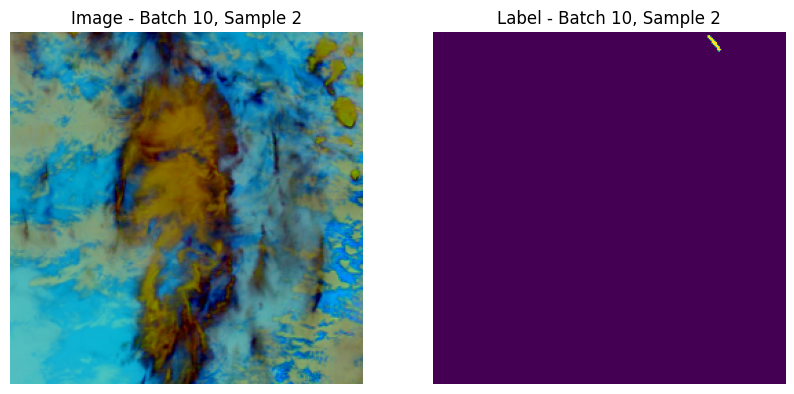

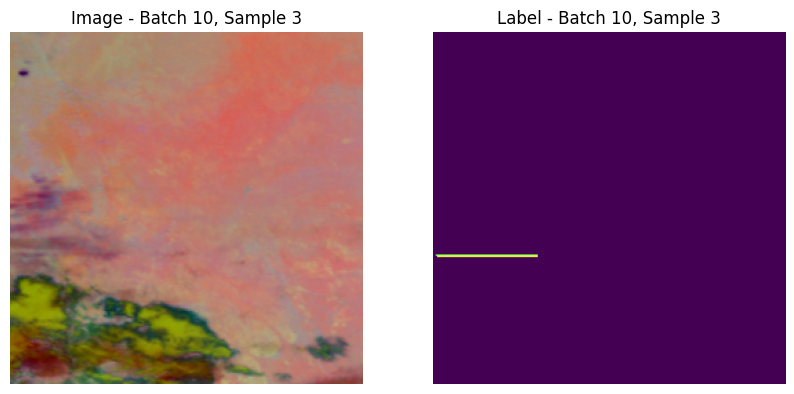

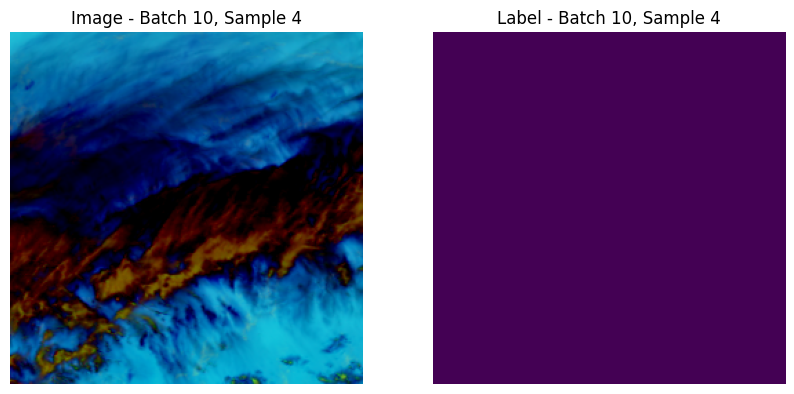

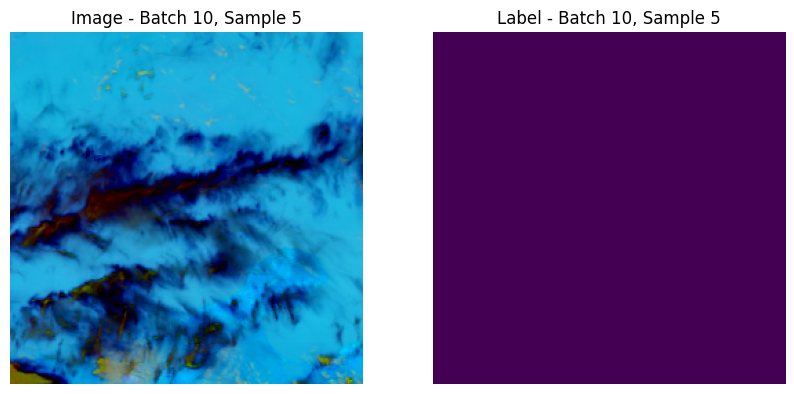

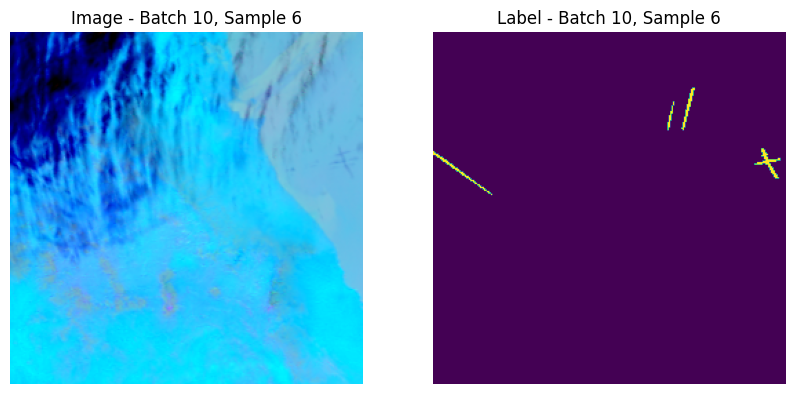

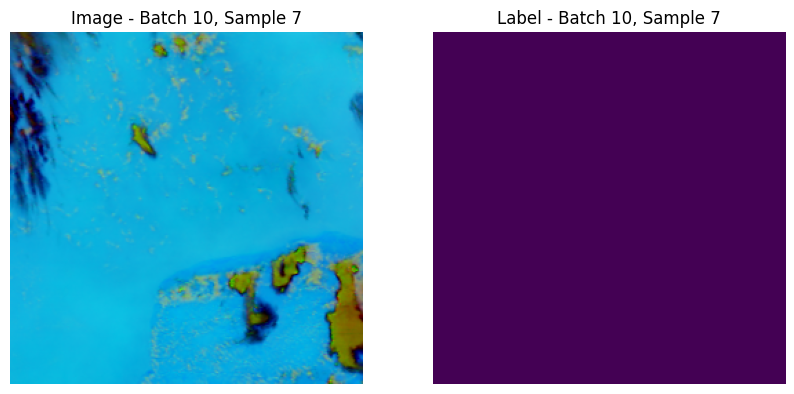

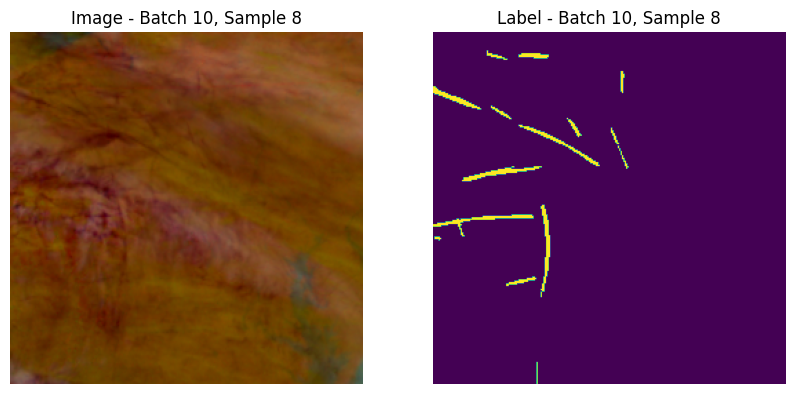

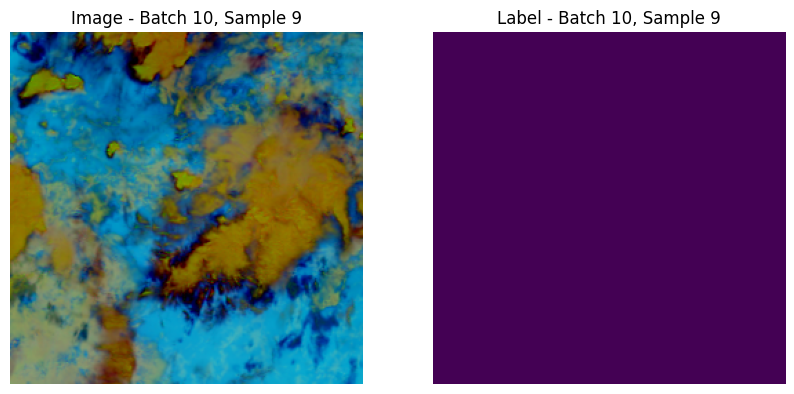

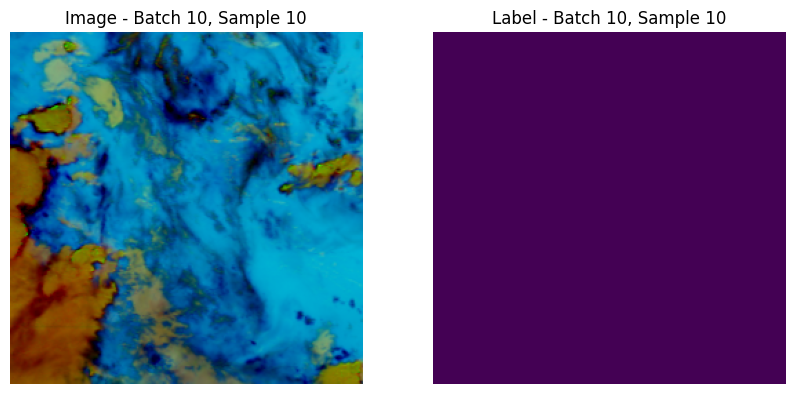

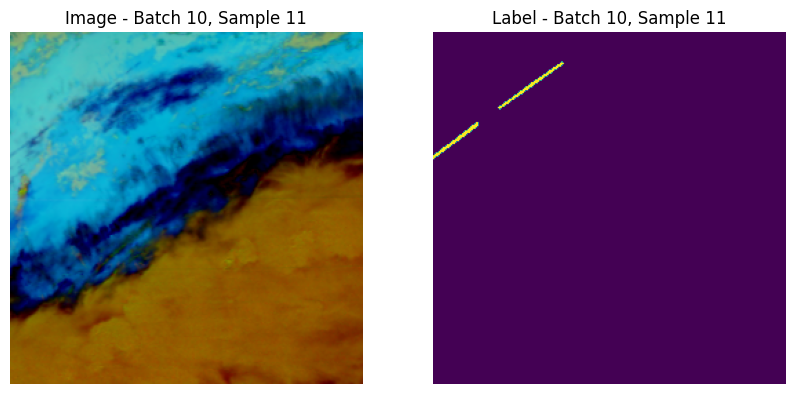

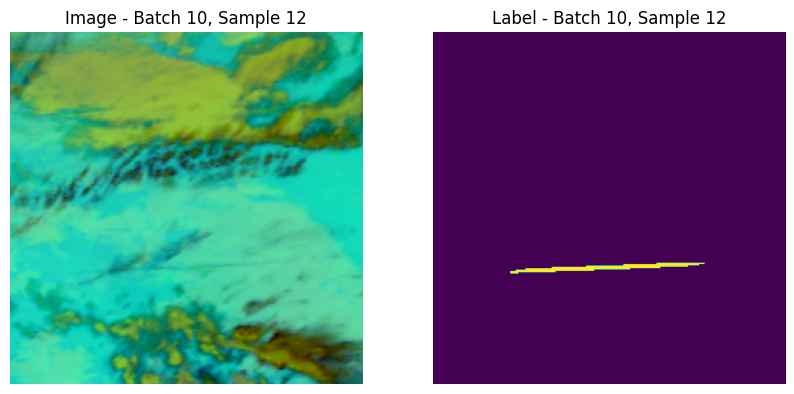

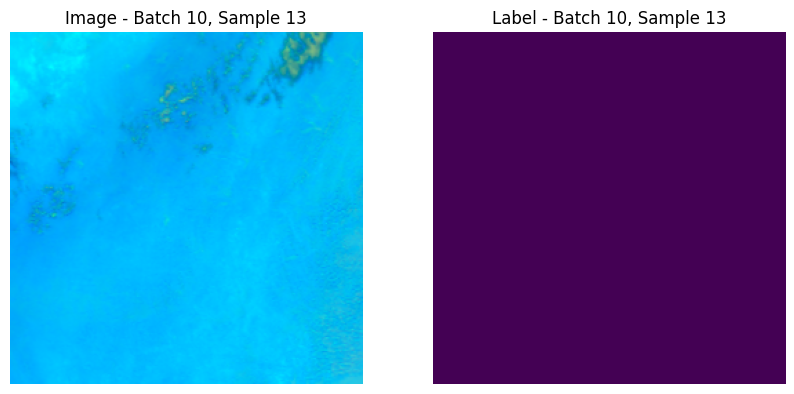

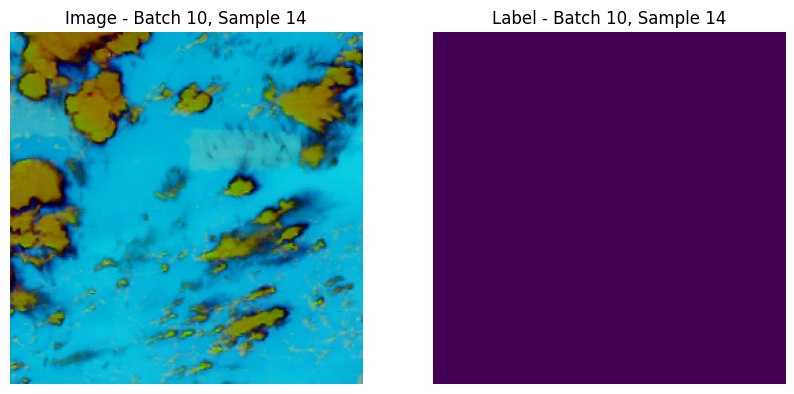

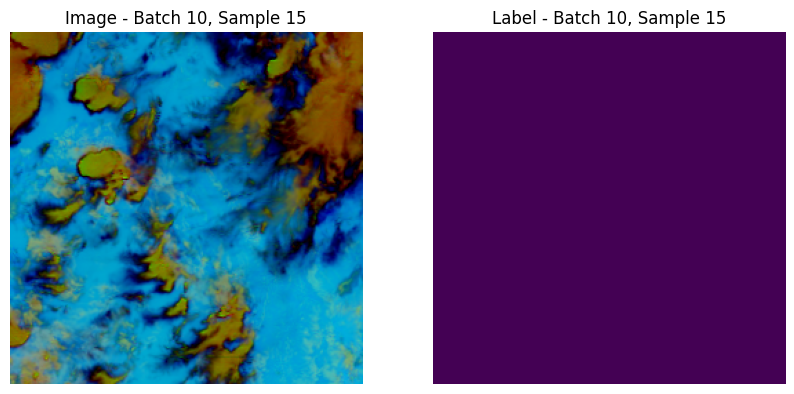

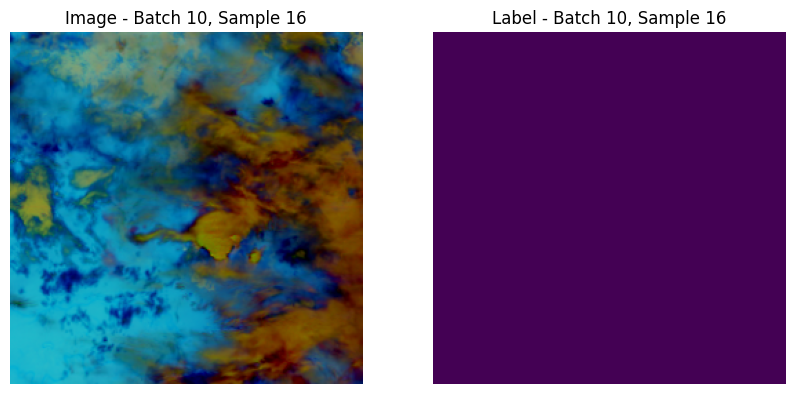

In [8]:
for j in range(batch_size):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(batch_images[j])
    plt.title(f"Image - Batch {i + 1}, Sample {j + 1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(batch_labels[j])
    plt.title(f"Label - Batch {i + 1}, Sample {j + 1}")
    plt.axis('off')

    plt.show()

In [9]:
def dice_coef(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    return (2.0 * intersection + smooth) / (union + smooth)

In [10]:
# U-Net model definition
def unet_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat5 = layers.concatenate([up5, conv3], axis=-1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat6 = layers.concatenate([up6, conv2], axis=-1)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv1], axis=-1)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [11]:
input_shape = (256, 256, 3)
model = unet_model()

In [12]:
model.compile(optimizer=Adam(learning_rate=3e-3), loss=binary_crossentropy, metrics=[dice_coef, 'accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [13]:
images_train, images_temp, labels_train, labels_temp = train_test_split(all_images, all_labels, test_size=0.4, random_state=1)
images_val, images_test, labels_val, labels_test = train_test_split(images_temp, labels_temp, test_size=0.5, random_state=1)

In [ ]:
labels_train = np.expand_dims(labels_train, axis=-1)
labels_val = np.expand_dims(labels_val, axis=-1)
labels_test = np.expand_dims(labels_test, axis=-1)

In [14]:
images_val.shape, labels_val.shape

((32, 256, 256, 3), (32, 256, 256))

In [15]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [16]:
import pandas as pd
model_path = os.path.join('/content/drive/MyDrive/', 'contrail_segmentation_model.h5')
history_path = os.path.join('/content/drive/MyDrive/', 'training_history.csv')

# Parameters
batch_size = 32
epochs = 10

# Train the model
history = model.fit( images_train, labels_train, epochs=epochs, validation_data=(images_val, labels_val))

# Save the model
model.save(model_path)

# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(history_path, index=False)

Epoch 1/10
3/3 [==============================] - 44s 2s/step - loss: 0.4414 - dice_coef: 0.2575 - accuracy: 0.6662 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 6/10
3/3 [==============================] - 3s 1s/step - loss: 0.0858 - dice_coef: 0.845

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
history = model.fit( images_train, labels_train, epochs=epochs, validation_data=(images_val, labels_val))


Epoch 1/10
3/3 [==============================] - 4s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 0.0858 - dice_coef: 0.8452 - accuracy: 0.9944 - val_loss: 0.0948 - val_dice_coef: 0.8259 - val_accuracy: 0.9939
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.0858 - dice_coef: 0.8452

In [18]:
pred = model.predict(images_test)

1/1 [==============================] - 0s 236ms/step


In [19]:
pred[0].shape

(256, 256, 1)

In [23]:
evaluation = model.evaluate(images_test, labels_test, batch_size=32)

1/1 [==============================] - 0s 466ms/step - loss: 0.0531 - dice_coef: 0.8662 - accuracy: 0.9966
